In [1]:
# Load useful packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime, timedelta
import numpy as np
import pyproj
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdate
import intake
import cftime

In [2]:
# Import SIC observations
sat = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [3]:
# Change co-ordinates
# Output coordinates are in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')

# Input coordinates are in meters on the Polar Stereographic 
# projection given in the netCDF file
projIn = pyproj.Proj(init='epsg:3411',
    preserve_units=True)

xx, yy = np.meshgrid( sat.x.values, sat.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
sat['lon'] = (('y','x'),lon)
sat['lat'] = (('y','x'),lat)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_349/3463951465.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.tr

In [16]:
# Select area of interest: Siberian Sea
sat_SS = sat.where((sat.lon>= 100) & 
                   (sat.lon<= 160) & 
                   (sat.lat<= 80) & 
                   (sat.lat>= 70),drop = True) 

sat_GL = sat.where((sat.lon>= -10) & 
                   (sat.lon<= 10) & 
                   (sat.lat<= 85) & 
                   (sat.lat>= 70),drop = True) 



In [19]:
sat_GL

<xarray.Dataset>
Dimensions:              (time: 6117, y: 236, x: 236)
Coordinates:
  * x                    (x) float64 3.156e+05 3.219e+05 ... 1.778e+06 1.784e+06
  * y                    (y) float64 -1.784e+06 -1.778e+06 ... -3.156e+05
  * time                 (time) datetime64[ns] 2002-06-01 ... 2019-12-31
Data variables:
    polar_stereographic  (time, y, x) object dask.array<chunksize=(30, 236, 236), meta=np.ndarray>
    z                    (time, y, x) float32 dask.array<chunksize=(30, 236, 236), meta=np.ndarray>
    lon                  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    lat                  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Sun Jun 21 02:48:54 2020: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSRE sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

In [20]:
area = 6.25**2
with ProgressBar():
    #iceExt = ((xr.where(sat_SS.z>15, 1.,0).sum(dim=['x','y']))*area ).compute()
    iceExt = ((xr.where(sat_GL.z>15, 1.,0).sum(dim=['x','y']))*area ).compute()
iceExt=xr.where(iceExt>0,iceExt,np.NaN)

[########################################] | 100% Completed | 164.02 s


In [21]:
#ys = np.unique(sat_SS.time.dt.year)
ys = np.unique(sat_GL.time.dt.year)
doy= np.arange(150,330)
t2d = np.array([
    [np.datetime64(str(y)) + np.timedelta64(d, 'D') for d in doy ] 
        for y in ys])

In [22]:
ice2d = np.array([
        [ iceExt.sel(time=d) if d in iceExt.time else np.NaN for d in y ]
            for y in t2d ])

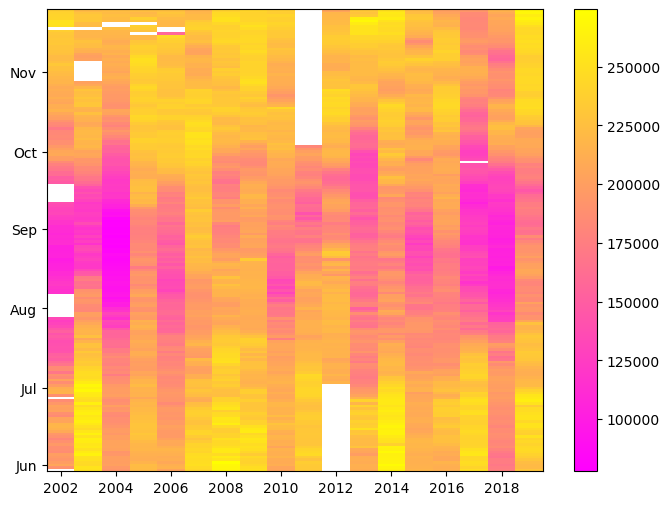

In [23]:
fig, ax = plt.subplots(figsize = (8,6))

pl=ax.pcolormesh(ys, 
            [np.datetime64('2000') + np.timedelta64(d, 'D') for d in doy], 
               ice2d.T,
                cmap=plt.colormaps['spring']
)
fig.colorbar(pl)


fmt = mdate.DateFormatter('%b')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(mdate.MonthLocator())

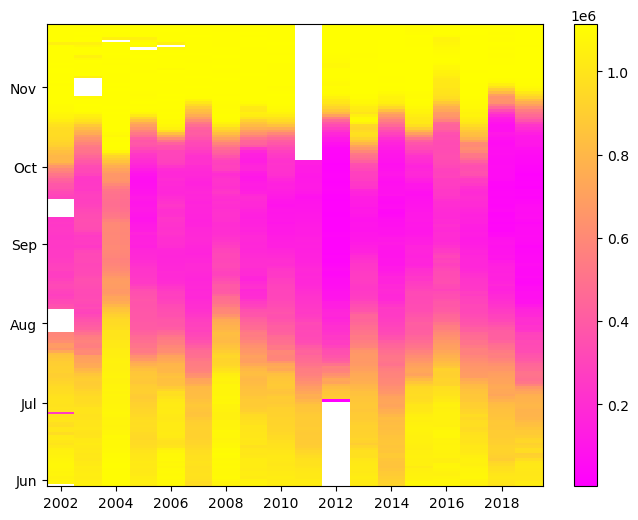

In [15]:
fig, ax = plt.subplots(figsize = (8,6))

pl=ax.pcolormesh(ys, 
            [np.datetime64('2000') + np.timedelta64(d, 'D') for d in doy], 
               ice2d.T,
                cmap=plt.colormaps['spring']
)
fig.colorbar(pl)

fmt = mdate.DateFormatter('%b')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(mdate.MonthLocator())
